In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import math
import time

import numpy as np
np.random.seed(1)
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, History, Callback, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from keras import backend as K



Using TensorFlow backend.


In [2]:
def prepare_training_data(df_F, df_D, df_Dt, d):
    
    #df_F1 = pd.DataFrame(df_F[df_F.columns[-1]])
    DF = []
    for ii in range(d):
        if ii == 0:
            DF = np.concatenate((df_F.shift(d-ii).values, df_D.shift(d-ii).values, df_Dt.shift(d-ii).values), axis = 1)
        else:
            DF = np.concatenate((DF, df_F.shift(d-ii).values, df_D.shift(d-ii).values, df_Dt.shift(d-ii).values), axis=1)

    DF = DF[d:,:]
    Dy = np.concatenate((df_D.values, df_Dt.values), axis=1)
    Dy = Dy[d:,:]
    
    return DF, Dy

In [3]:
def train_test_split(DF, Dy, d, x_scaler, y_scaler, train_portion, set_length, n_sets):

    dim = np.shape(Dy)

    n_nodes = int(dim[1]/2)
    n_y = dim[1]
    x = np.linspace(0,1, n_nodes)

    #Scaling
    DFscaled = x_scaler.transform(DF)
    Dyscaled = y_scaler.transform(Dy)

    #X_train = DFscaled
    #Y_train = Dyscaled

    #Train test split
    #train_portion = 0.8
    n_features = int(DF.shape[1]/d)
    #n_timesteps = len(X_train[:,0])
    
    L = int(set_length*train_portion)
    U = int(set_length*(1-train_portion))
    
    x_train = np.zeros([n_sets*L, n_features*d])
    y_train = np.zeros([n_sets*L, n_y])
    
    x_test = np.zeros([n_sets, U, d, n_features])
    y_test = np.zeros([n_sets, U, n_y])
    
    for set_i in range(n_sets):
        X_i = DFscaled[set_length*set_i:set_length*(set_i+1),:]
        Y_i = Dyscaled[set_length*set_i:set_length*(set_i+1),:]
        x_train[L*set_i:L*(set_i+1),:] = X_i[0:L,:]
        y_train[L*set_i:L*(set_i+1),:] = Y_i[0:L,:]
        
        x_test_m = X_i[L:-1,:]
        y_test_m = Y_i[L:-1,:]
        
        x_test[set_i] = x_test_m.reshape((U, d, n_features))
        y_test[set_i] = y_test_m

    
    #Reshape training data into 3D array as required by the LSTM layer
    #Input shape is: (n_timesteps, d, n_features)
    x_train = x_train.reshape((x_train.shape[0], d, n_features))
    #x_test = x_test.reshape((x_test.shape[0], d, n_features))

    return x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x

In [5]:
def get_error(predictions, ytest):
    #Squared error is integrated numerically in space for each timestep and summed
    error = 0
    for i in range(len(predictions[:,0])):
        error += np.trapz((ytest[i,:] - predictions[i,:])**2, x)
    return error

In [8]:
def get_scalers(DF, Dy):
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    x_scaler.fit_transform(DF)
    y_scaler.fit_transform(Dy)
    
    return x_scaler, y_scaler

In [11]:
def get_batch(x_train, y_train, batch_size, set_length, n_sets):
    
    set_number = randint(0, n_sets)
    start = random.randint(0,set_length-batch_size)*set_number*set_length
    
    x_batch = x_train[start:start+batch_size]
    y_batch = y_train[start:start+batch_size]
    
    return x_batch, y_batch

In [12]:
class Ind_pred(Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        
        error = 0
        if epoch > 400 or epoch%10 == 0:
            input_i = np.copy(x_test[0,:,:]) #Initial conditions
            #input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

            future_timesteps = len(x_test[:,0,0])-1
            preds = np.zeros([future_timesteps, n_y])

            force = np.copy(x_test[:,:,0]) #Loading history for future timesteps, which is known

            new_step = np.zeros(len(x_test[0,0,:]))
            input_shape = input_i.shape

            for i in range(future_timesteps): 

                input_i_pca = pca.transform(input_i.reshape([input_shape[0], input_shape[1]]))

                pred = self.model.predict(input_i_pca.reshape([1,d,n_features])) #Predict next timestep
                preds[i, :] = pred[0] 

                input_i[0:d-1,:] = input_i[1:d,:] #Move everything one step backward
                new_step[0] = force[i+1,d-1] #Fill in force for next timestep
                new_step[1:] = pred[0] #Fill in values that we just predicted


                input_i[d-1,:] = new_step.reshape([1,len(new_step)])


            error = 0
            for i in range(len(preds[:,0])):
                error += np.trapz((y_test[i,:n_nodes] - preds[i,:n_nodes])**2, x)

        info = {'ind error': error}
        u_ind_errors.append(error)

        logs['ind_error'] = error

        print(info)
    
    #def on_batch_end(self, batch, logs={}):
    #    print(batch)

In [13]:
def independent_predictions_pca(x_test, my_model):        
    input_i = np.copy(x_test[0,:,:]) #Initial conditions
    #input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

    future_timesteps = len(x_test[:,0,0])-1
    preds = np.zeros([future_timesteps, n_y])

    force = np.copy(x_test[:,:,0]) #Loading history for future timesteps, which is known

    new_step = np.zeros(len(x_test[0,0,:]))
    input_shape = input_i.shape

    for i in range(future_timesteps): 

        input_i_pca = pca.transform(input_i.reshape([input_shape[0], input_shape[1]]))

        pred = my_model.predict(input_i_pca.reshape([1,d,n_features])) #Predict next timestep
        preds[i, :] = pred[0] 

        input_i[0:d-1,:] = input_i[1:d,:] #Move everything one step backward
        new_step[0] = force[i+1,d-1] #Fill in force for next timestep
        new_step[1:] = pred[0] #Fill in values that we just predicted


        input_i[d-1,:] = new_step.reshape([1,len(new_step)])
        
    return preds

In [28]:
#Mass import

#X_train = np.zeros([95,34200,d,n_features]) 
#DF_total = np.zeros()
training_set = 'mass_production_white_noise_resonance'
d = 20
train_portion = 0.95
n = 100
s = 3600-d-1
DF_total = np.zeros([s*n, 21*d])
Dy_total = np.zeros([s*n, 20])

for i in range(n):

    iteration = i #5*i+5

    #Import training data
    df_D = pd.read_csv('../training_batches/'+ training_set +'D' + str(iteration) + '.csv')
    df_F = pd.read_csv('../training_batches/'+ training_set +'F' + str(iteration) + '.csv')
    df_Dt = pd.read_csv('../training_batches/'+ training_set +'Dt' + str(iteration) + '.csv')

    #Prepare training data
    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    DF_total[i*s:s*(i+1),:] = DF[:]
    Dy_total[i*s:s*(i+1),:] = Dy[:]
    
    

In [29]:
# Get scalers
x_scaler, y_scaler = get_scalers(DF_total, Dy_total)


In [30]:
#Split into train and test set
x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x = train_test_split(DF_total, Dy_total, d, x_scaler, y_scaler, 
                                                                                 train_portion, s, n)

In [31]:
####Method 1####
train_shape = x_train.shape
test_shape = x_test.shape

x_train2 = x_train.reshape([train_shape[0]*train_shape[1],train_shape[2]])
#x_test2 = x_test.reshape([test_shape[0]*test_shape[1],test_shape[2]])

NCOMPONENTS = 5

pca = PCA(n_components=NCOMPONENTS)
X_pca_train = pca.fit_transform(x_train2)
#X_pca_test = pca.transform(x_test2)
pca_std = np.std(X_pca_train)

In [33]:
sh1 = X_pca_train.shape
x_train_pca = X_pca_train.reshape([int(sh1[0]/d),d,sh1[1]])

In [34]:
set_length = int(x_train_pca.shape[0]/n)

In [35]:
######################### BATCH TRAINING ########################################

n_batches = 1
#d = 10

#Hyperparameter settings
epochs = 500
layers = 1
height = 100
batch_size = 1000
lr = 0.01
u_errors_matrix = []
c_errors_matrix =[]

In [36]:
n_features = sh1[1]

In [37]:
############## Initialize model #####################
t0 = time.time()
bt_model = Sequential()
bt_model.add(LSTM(height, batch_input_shape=(None, d, n_features), return_sequences=False))
bt_model.add(Dense(len(y_train[0,:]))) #Output Layer
adam = Adam(lr=lr)
bt_model.compile(loss='mae', optimizer=adam)

#Define callbacks
ind_pred = Ind_pred()
history = History()
earlystop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=15, min_lr=0.0001, mode='min', verbose=1)
model_cp = ModelCheckpoint('../results/model_checkpoint.h5', monitor='ind_error', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)

bt_ind_errors = []

In [55]:

batch_size = 1000
n_sets = n
batch_iterations = int(set_length/batch_size)*n_sets
lowest = 1
since_lowest = 0
patience = 5
losses = np.zeros(batch_iterations)
avg_losses = []
for tr_set in range(1):
    for epoch in range(epochs):
        for bi in range(batch_iterations):
            
            set_number = random.randint(0, n_sets-1)
            start = set_number*set_length + random.randint(0,set_length-batch_size)

            x_batch = x_train_pca[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            hist = bt_model.train_on_batch(x_batch, y_batch)
            
            losses[bi] = hist
            
        
        avg_loss = losses.mean()
        avg_losses.append(avg_loss)
        
        if epoch > 200:
            bt_pred_ind_all = independent_predictions_pca(x_test, bt_model)
            bt_pred_ind = bt_pred_ind_all[:, 0]
            bt_ind_error = get_error(bt_pred_ind, y_test_r[0:len(bt_pred_ind),0])

            bt_ind_errors.append(bt_ind_error)
        elif epoch%5 == 0:
            
            test_set_number = random.randint(0, n_sets-1)
            #start = set_number*set_length
            x_test_r = x_test[test_set_number]
            y_test_r = y_test[test_set_number]
            
            bt_pred_ind_all = independent_predictions_pca(x_test_r, bt_model)
            bt_pred_ind = bt_pred_ind_all[:, 0:n_nodes]
            bt_ind_error = get_error(bt_pred_ind, y_test_r[0:len(bt_pred_ind),0:n_nodes])

            bt_ind_errors.append(bt_ind_error)
            
            if bt_ind_error < 3.0:
                bt_model.save('../models/white_noise_NL_' + str(epoch) + '.h5')
        else:
            bt_ind_error = 0

        if avg_loss < lowest:
            lowest = avg_loss
            reduce = 'no'
            since_lowest = 0
        else: 
            if since_lowest == patience:
                
                if lr >= 0.0001:
                    lr *= 0.2
                    K.set_value(bt_model.optimizer.lr, lr)
                    reduce = 'yes'
                    since_lowest = 0
                elif lr > 0.00001:
                    K.set_value(bt_model.optimizer.lr, 0.00001)
                    lr = 0.00001
                    reduce = 'yes'
                    since_lowest = 0
            else:
                since_lowest += 1
                reduce = 'no' 
        
        info = {'epoch':epoch, 'loss': avg_loss, 'lr': lr, 'reduce': reduce, 'since_lowest': since_lowest}
        print(info)
        print({'ind_error': bt_ind_error})
        
#earlystop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=20, verbose=1, mode='auto')
#callback_list = [earlystop, history]
print({'total time': time.time()-t0})

{'epoch': 0, 'loss': 0.00040632037650842296, 'lr': 1e-05, 'reduce': 'no', 'since_lowest': 0}
{'ind_error': 0.039975555886297719}
{'epoch': 1, 'loss': 0.00039710401115977825, 'lr': 1e-05, 'reduce': 'no', 'since_lowest': 0}
{'ind_error': 0}
{'epoch': 2, 'loss': 0.00037364534374016028, 'lr': 1e-05, 'reduce': 'no', 'since_lowest': 0}
{'ind_error': 0}
{'epoch': 3, 'loss': 0.00039065483484591824, 'lr': 1e-05, 'reduce': 'no', 'since_lowest': 1}
{'ind_error': 0}
{'epoch': 4, 'loss': 0.0003813038035999246, 'lr': 1e-05, 'reduce': 'no', 'since_lowest': 2}
{'ind_error': 0}
{'epoch': 5, 'loss': 0.00037221541249891742, 'lr': 1e-05, 'reduce': 'no', 'since_lowest': 0}
{'ind_error': 0.0030789068334226601}
{'epoch': 6, 'loss': 0.00040719091057932628, 'lr': 1e-05, 'reduce': 'no', 'since_lowest': 1}
{'ind_error': 0}
{'epoch': 7, 'loss': 0.00037912004006405672, 'lr': 1e-05, 'reduce': 'no', 'since_lowest': 2}
{'ind_error': 0}
{'epoch': 8, 'loss': 0.00037857927635438196, 'lr': 1e-05, 'reduce': 'no', 'since_l

{'epoch': 72, 'loss': 0.00032556133030690643, 'lr': 1e-05, 'reduce': 'no', 'since_lowest': 5}
{'ind_error': 0}
{'epoch': 73, 'loss': 0.00032516970051801766, 'lr': 1e-05, 'reduce': 'no', 'since_lowest': 5}
{'ind_error': 0}
{'epoch': 74, 'loss': 0.00033627993419941047, 'lr': 1e-05, 'reduce': 'no', 'since_lowest': 5}
{'ind_error': 0}


KeyboardInterrupt: 

In [343]:
#lr *= 0.2
#K.set_value(bt_model.optimizer.lr, lr)

In [68]:
#Total ind_error

total_error = 0
n_sets = n
errors = []
for j in range(n_sets):

    x_test_r = x_test[j]
    y_test_r = y_test[j]
    
    t0 = time.time()
    bt_pred_ind_all = independent_predictions_pca(x_test_r, bt_model)
    t = time.time() - t0
    #print(t)
    bt_pred_ind = bt_pred_ind_all[:, 0:n_nodes]
    bt_ind_error = get_error(bt_pred_ind, y_test_r[0:len(bt_pred_ind[:,0]),0:n_nodes])
    
    #if j != 7 and j != 9:
    total_error += bt_ind_error
    errors.append(bt_ind_error)

print(errors)
print(total_error)

[2.9363026870095963, 1.2757094748987716, 1.3796918207334066, 1.2158213845765158, 2.353628329065991, 2.7528654436775235, 1.1220795536140242, 1.2384841777468971, 1.331392162690002, 1.2949757455478443, 1.1967837515155026, 15.854219591311137, 1.4903760627814617, 1.5503932749436826, 14.285113575552343, 1.4539121560775488, 1.2683975810523143, 1.7356262219933127, 1.1759889728169308, 1.1084803308123836, 1.1642586660760308, 1.777881618363192, 1.4147341370686419, 1.2044844884395383, 1.1882437417723728, 3.1201703716319082, 1.0447308194926561, 1.9417538757111223, 3.0553825332569757, 1.0672397957642765, 1.2804972845112368, 13.184330259974033, 2.5897324258094012, 1.2464504782379109, 1.7564553167512753, 13.96699963492066, 1.0897595951230477, 1.095662175140985, 2.2971826166534139, 1.2893800745801762, 3.2970708460177884, 1.5408728256235453, 1.5278459714377859, 1.4367105695109155, 3.3715918275902967, 1.7738086744118564, 1.3108377864332603, 1.1391032466545277, 1.9457684520135006, 2.4734700377433789, 1.17

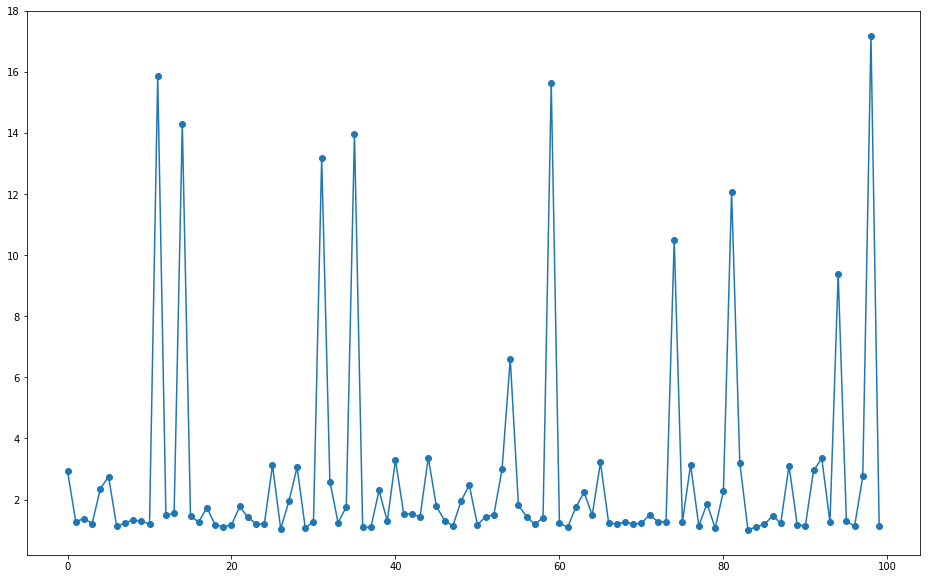

In [69]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
#plt.plot(bt_pred_ind[:,n_nodes-1])

#plt.plot(y_test_r[0:, n_nodes-1])
plt.plot(errors, '-o')
#plt.ylim(0, 10)

plt.show()

In [66]:

j = 0
x_test_r = x_test[j]
y_test_r = y_test[j]

bt_pred_ind_all = independent_predictions_pca(x_test_r, bt_model)
bt_pred_ind = bt_pred_ind_all[:, 0:n_nodes]
bt_ind_error = get_error(bt_pred_ind, y_test_r[0:len(bt_pred_ind[:,0]),0:n_nodes])
print(bt_ind_error)

2.93630268701


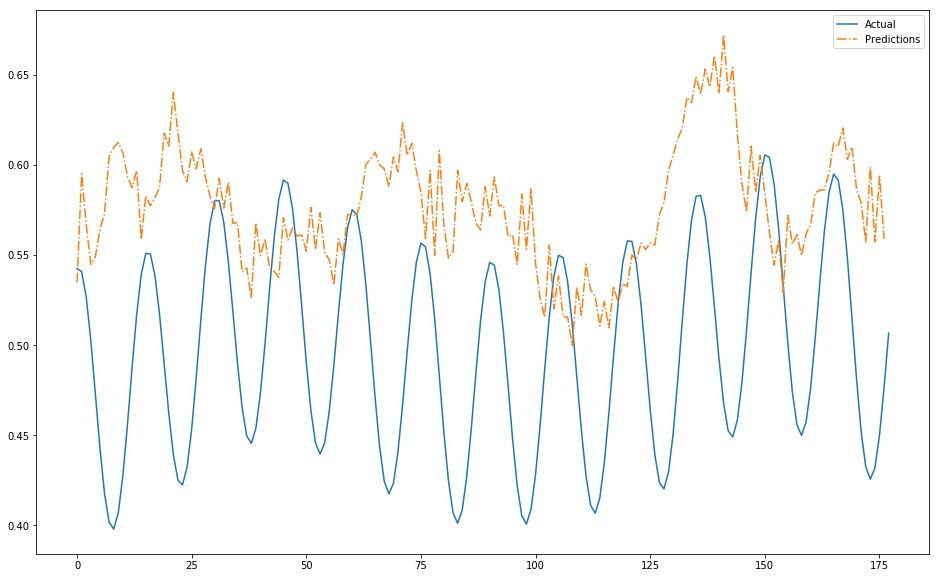

In [67]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
#plt.plot(bt_pred_ind[:,n_nodes-1])
#plt.plot(y_train[3000:5000,n_nodes-1])

plt.plot(y_test_r[:, n_nodes-1])
plt.plot(bt_pred_ind[:,n_nodes-1], '-.')


plt.legend(['Actual', 'Predictions'])
plt.show()

In [61]:
#save best model
#trained on= rr_set1

#bt_model.save('../models/mass_production_white_noise6.h5')

#### CONTINUE TRAINING ####
bt_model = load_model('../models/mass_production_white_noise6.h5')

#model.fit(x_train, y_train, epochs=100, verbose=1)

#model.save('beam_model.h5')

#del(model)

In [136]:
def generate_export(my_model):
    pred_train_all = my_model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]

    pred_test_all = my_model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]

    pred_ind_all = independent_predictions(x_test, my_model)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]

    y_test_u = y_scaler.inverse_transform(y_test)[:, 0:n_nodes]
    
    #Export results
    np.savetxt("../results/predictions.csv", pred_test_u, delimiter=",")
    np.savetxt("../results/preds.csv", pred_ind_u, delimiter=",")
    np.savetxt("../results/y_test.csv", y_test_u, delimiter=",")
    np.savetxt("../results/y_train.csv", y_test_u, delimiter=",")

In [316]:
#generate_export(u_model)

In [39]:
y_test_u = y_scaler.inverse_transform(y_test_r)[:, 0:n_nodes]
bt_pred_ind_u = y_scaler.inverse_transform(bt_pred_ind_all)[:, 0:n_nodes]

In [40]:
#Export results
#np.savetxt("../results/predictions.csv", pred_test_u, delimiter=",")
np.savetxt("../results/preds.csv", bt_pred_ind_u, delimiter=",")
np.savetxt("../results/y_test.csv", y_test_u, delimiter=",")
#np.savetxt("../results/y_train.csv", y_test_u, delimiter=",")